In [ ]:
 import torch

In [ ]:
# !pip install wget

In [ ]:
# import wget

# url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
# wget.download(url)

In [ ]:
# import zipfile
# with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')


In [ ]:
import os
from pathlib import Path

path = Path('/content/drive/MyDrive/DatasetSegmentacion')
img_dir = path / 'bolsa'
mask_dir = path / 'segmentaciones'

imgs = [img_dir / i for i in os.listdir(img_dir)]
masks = []

for img_path in imgs:
    img_name = img_path.stem  # Obtener el nombre del archivo sin la extensión
    mask_name = img_name + '_mask.png'  # Construir el nombre del archivo de la máscara
    mask_path = mask_dir / mask_name  # Ruta completa de la máscara
    masks.append(mask_path)

print(len(imgs), len(masks))

1008 1008


In [ ]:
print(imgs[1])
print(masks[1])

/content/drive/MyDrive/DatasetSegmentacion/bolsa/0022_jpg.rf.ea9dc7374b10f18b4d66ce34fcc36ab2.jpg
/content/drive/MyDrive/DatasetSegmentacion/segmentaciones/0022_jpg.rf.ea9dc7374b10f18b4d66ce34fcc36ab2_mask.png


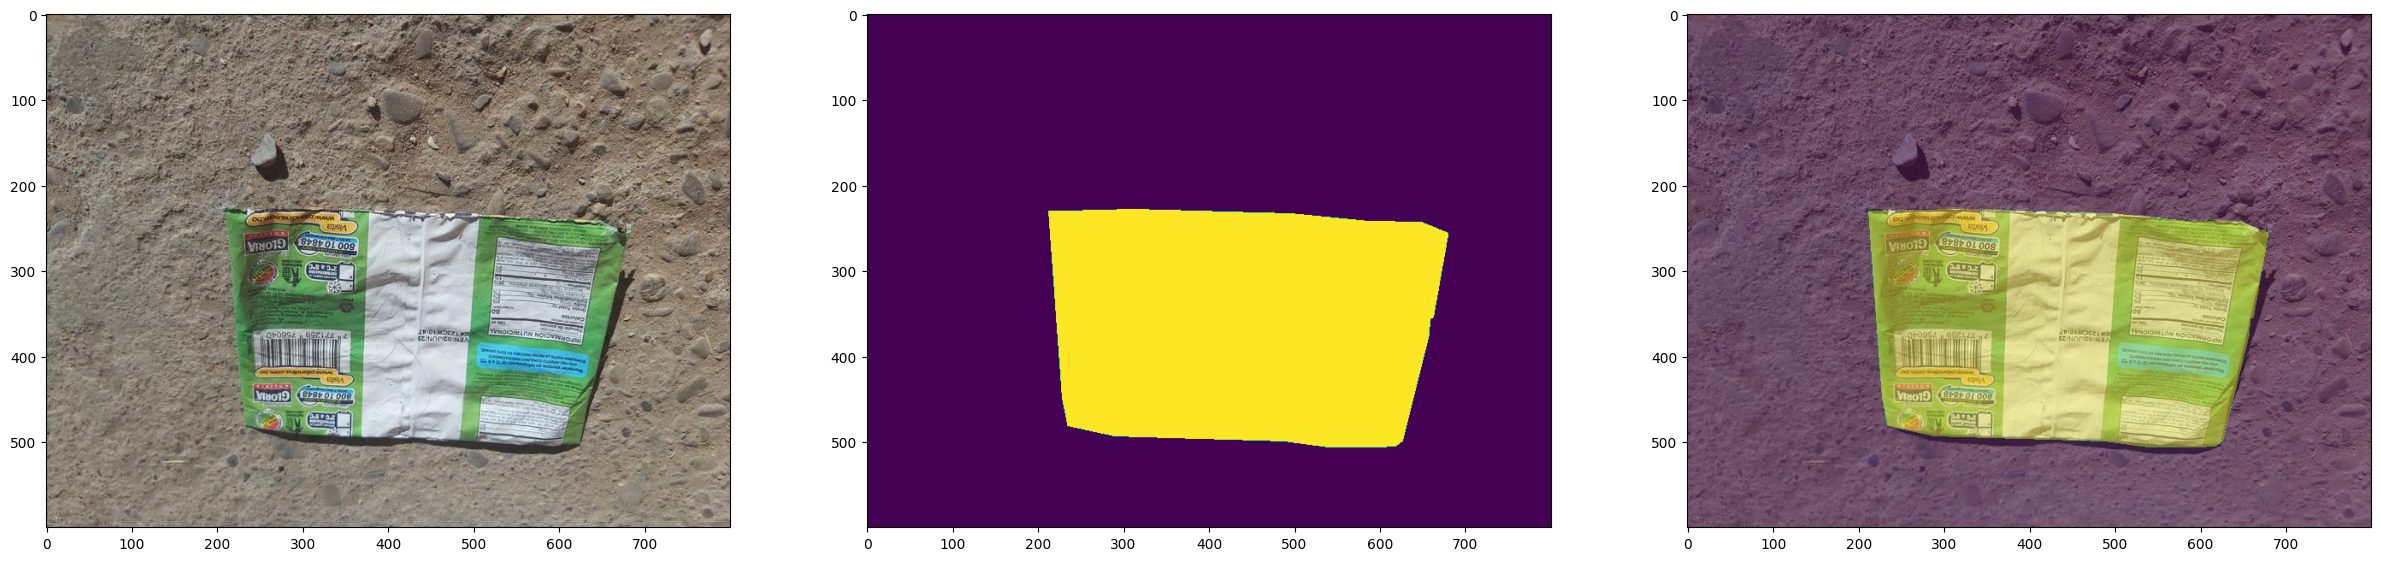

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
imagen = Image.open(imgs[0])
mascara = Image.open(masks[0])
img = np.array(imagen)
mask = np.array(mascara)
# img = np.load(imgs[0])
# mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [ ]:
img.shape, img.dtype, img.max(), img.min()

((600, 800, 3), dtype('uint8'), 255, 0)

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [ ]:
mask.shape, mask.dtype, mask.max(), mask.min()

((600, 800), dtype('uint8'), 1, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [ ]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((600, 800, 3), dtype('float32'), 1.0, 0.0)

In [ ]:
from skimage import io

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # img = np.array(Image.open(self.X[ix]))
    # mask = np.array(Image.open(self.y[ix]))
    img = Image.open(self.X[ix])
    mask = Image.open(self.y[ix])

    # Redimensionar imágenes
    img = img.resize((324,324))
    mask = mask.resize((324,324))

    img = np.array(img)
    mask = np.array(mask)
    img = torch.from_numpy(img / 255.).float().permute(2,0,1).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img.squeeze(), torch.from_numpy(mask).permute(2,0,1)

In [ ]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(908, 100)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=3, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 324, 324]), torch.Size([5, 3, 324, 324]))

In [ ]:
imgs[0]

tensor([[[0.2824, 0.2980, 0.3294,  ..., 0.6706, 0.5961, 0.5686],
         [0.2980, 0.3176, 0.3412,  ..., 0.6863, 0.6235, 0.5765],
         [0.3176, 0.3373, 0.3529,  ..., 0.6824, 0.6471, 0.5922],
         ...,
         [0.7020, 0.6941, 0.7216,  ..., 0.6706, 0.6784, 0.6824],
         [0.6235, 0.6471, 0.6941,  ..., 0.6745, 0.6863, 0.6902],
         [0.6196, 0.6118, 0.6157,  ..., 0.6784, 0.6863, 0.6980]],

        [[0.2784, 0.2941, 0.3255,  ..., 0.6431, 0.5647, 0.5373],
         [0.2941, 0.3137, 0.3373,  ..., 0.6588, 0.5922, 0.5451],
         [0.3137, 0.3333, 0.3490,  ..., 0.6627, 0.6196, 0.5608],
         ...,
         [0.6431, 0.6314, 0.6510,  ..., 0.6941, 0.6980, 0.7020],
         [0.5647, 0.5843, 0.6235,  ..., 0.6941, 0.7059, 0.7098],
         [0.5608, 0.5490, 0.5451,  ..., 0.6980, 0.7059, 0.7176]],

        [[0.2706, 0.2863, 0.3098,  ..., 0.6000, 0.5216, 0.4902],
         [0.2863, 0.3059, 0.3255,  ..., 0.6196, 0.5490, 0.5020],
         [0.3059, 0.3255, 0.3333,  ..., 0.6196, 0.5765, 0.

In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
import torchvision
import torch

In [ ]:
# encoder = torchvision.models.resnet18(pretrained=True)
# encoder
# encoder = torchvision.models.googlenet(pretrained=True)
# encoder

encoder = torchvision.models.vgg.vgg16(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 284MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [ ]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, kernel_size=4, stride=2, padding=1)
        self.conv1 = conv3x3_bn(ci + co, co)
        self.conv2 = conv3x3_bn(co, co)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (0, diffY, 0, diffX))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [ ]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.vgg.vgg16(pretrained=True)
        if in_ch != 3:
            self.encoder.features[0] = torch.nn.Conv2d(
                in_ch, 64, kernel_size=3, stride=1, padding=1, bias=False
            )

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.features[:4](x)
        # print("X: ",x.shape)
        x1 = self.encoder.features[5:10](x)
        # print("X1: ",x1.shape)
        x2 = self.encoder.features[10:17](x1)
        # print("X2: ",x2.shape)
        x3 = self.encoder.features[17:24](x2)
        # print("X3: ",x3.shape)
        x = self.encoder.features[24:](x3)
        # print("X: ",x.shape)
        x = self.deconv1(x, x3)
        # print("X Deconv: ",x.shape)
        x = self.deconv2(x, x2)
        # print("X Deconv: ",x.shape)
        x = self.deconv3(x, x1)
        # print("X Deconv: ",x.shape)
        x = self.out(x, x_in)
        # print("X Deconv: ",x.shape)
        return x

In [ ]:
model = UNetResnet(in_ch=3)
# output = model(torch.randn((5,1,394,394)))
# output.shape

In [ ]:
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/182 [00:00<?, ?it/s]<ipython-input-21-0dca32de9b5e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.19725 test_iou 0.80442: 100%|██████████| 34/34 [00:33<00:00,  1.02it/s]



Epoch 1/30 loss 0.30481 iou 0.80550 test_loss 0.19725 test_iou 0.80442


test_loss 0.09756 test_iou 0.87254: 100%|██████████| 34/34 [00:09<00:00,  3.64it/s]



Epoch 2/30 loss 0.13314 iou 0.86300 test_loss 0.09756 test_iou 0.87254


test_loss 0.08502 test_iou 0.87080: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]



Epoch 3/30 loss 0.08292 iou 0.88883 test_loss 0.08502 test_iou 0.87080


test_loss 0.08438 test_iou 0.86471: 100%|██████████| 34/34 [00:08<00:00,  3.84it/s]



Epoch 4/30 loss 0.06417 iou 0.89552 test_loss 0.08438 test_iou 0.86471


test_loss 0.08234 test_iou 0.84578: 100%|██████████| 34/34 [00:09<00:00,  3.76it/s]



Epoch 5/30 loss 0.05680 iou 0.89837 test_loss 0.08234 test_iou 0.84578


test_loss 0.07811 test_iou 0.87048: 100%|██████████| 34/34 [00:08<00:00,  3.78it/s]



Epoch 6/30 loss 0.04751 iou 0.90738 test_loss 0.07811 test_iou 0.87048


test_loss 0.05623 test_iou 0.89512: 100%|██████████| 34/34 [00:08<00:00,  3.85it/s]



Epoch 7/30 loss 0.04265 iou 0.91505 test_loss 0.05623 test_iou 0.89512


test_loss 0.18366 test_iou 0.75396: 100%|██████████| 34/34 [00:08<00:00,  3.96it/s]



Epoch 8/30 loss 0.03627 iou 0.92550 test_loss 0.18366 test_iou 0.75396


test_loss 0.07309 test_iou 0.83108: 100%|██████████| 34/34 [00:08<00:00,  3.92it/s]



Epoch 9/30 loss 0.03566 iou 0.92599 test_loss 0.07309 test_iou 0.83108


test_loss 0.04187 test_iou 0.90927: 100%|██████████| 34/34 [00:08<00:00,  3.81it/s]



Epoch 10/30 loss 0.02918 iou 0.93748 test_loss 0.04187 test_iou 0.90927


test_loss 0.04524 test_iou 0.90843: 100%|██████████| 34/34 [00:09<00:00,  3.76it/s]



Epoch 11/30 loss 0.02791 iou 0.93977 test_loss 0.04524 test_iou 0.90843


test_loss 0.04261 test_iou 0.89789: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]



Epoch 12/30 loss 0.02406 iou 0.94611 test_loss 0.04261 test_iou 0.89789


test_loss 0.05520 test_iou 0.90505: 100%|██████████| 34/34 [00:08<00:00,  3.83it/s]



Epoch 13/30 loss 0.02081 iou 0.95089 test_loss 0.05520 test_iou 0.90505


test_loss 0.05748 test_iou 0.88807: 100%|██████████| 34/34 [00:08<00:00,  3.96it/s]



Epoch 14/30 loss 0.01791 iou 0.95823 test_loss 0.05748 test_iou 0.88807


test_loss 0.04273 test_iou 0.92194: 100%|██████████| 34/34 [00:08<00:00,  3.92it/s]



Epoch 15/30 loss 0.02278 iou 0.94800 test_loss 0.04273 test_iou 0.92194


test_loss 0.04397 test_iou 0.91791: 100%|██████████| 34/34 [00:08<00:00,  3.83it/s]



Epoch 16/30 loss 0.01291 iou 0.96747 test_loss 0.04397 test_iou 0.91791


test_loss 0.05920 test_iou 0.89513: 100%|██████████| 34/34 [00:08<00:00,  3.79it/s]



Epoch 17/30 loss 0.01370 iou 0.96584 test_loss 0.05920 test_iou 0.89513


test_loss 0.05531 test_iou 0.91077: 100%|██████████| 34/34 [00:08<00:00,  3.79it/s]



Epoch 18/30 loss 0.01487 iou 0.96346 test_loss 0.05531 test_iou 0.91077


test_loss 0.04897 test_iou 0.91573: 100%|██████████| 34/34 [00:08<00:00,  3.79it/s]



Epoch 19/30 loss 0.01351 iou 0.96634 test_loss 0.04897 test_iou 0.91573


test_loss 0.04965 test_iou 0.91966: 100%|██████████| 34/34 [00:09<00:00,  3.77it/s]



Epoch 20/30 loss 0.00943 iou 0.97458 test_loss 0.04965 test_iou 0.91966


test_loss 0.05205 test_iou 0.90727: 100%|██████████| 34/34 [00:08<00:00,  3.81it/s]



Epoch 21/30 loss 0.00859 iou 0.97702 test_loss 0.05205 test_iou 0.90727


test_loss 0.04876 test_iou 0.92066: 100%|██████████| 34/34 [00:08<00:00,  3.98it/s]



Epoch 22/30 loss 0.00936 iou 0.97469 test_loss 0.04876 test_iou 0.92066


test_loss 0.06302 test_iou 0.89475: 100%|██████████| 34/34 [00:08<00:00,  3.93it/s]



Epoch 23/30 loss 0.01348 iou 0.96495 test_loss 0.06302 test_iou 0.89475


test_loss 0.05663 test_iou 0.90947: 100%|██████████| 34/34 [00:08<00:00,  3.84it/s]



Epoch 24/30 loss 0.01188 iou 0.96951 test_loss 0.05663 test_iou 0.90947


test_loss 0.06319 test_iou 0.89994: 100%|██████████| 34/34 [00:09<00:00,  3.75it/s]



Epoch 25/30 loss 0.01462 iou 0.96324 test_loss 0.06319 test_iou 0.89994


test_loss 0.05837 test_iou 0.91396: 100%|██████████| 34/34 [00:08<00:00,  3.81it/s]



Epoch 26/30 loss 0.00662 iou 0.98131 test_loss 0.05837 test_iou 0.91396


test_loss 0.04554 test_iou 0.92894: 100%|██████████| 34/34 [00:08<00:00,  3.78it/s]



Epoch 27/30 loss 0.00579 iou 0.98354 test_loss 0.04554 test_iou 0.92894


test_loss 0.05059 test_iou 0.92973: 100%|██████████| 34/34 [00:08<00:00,  3.84it/s]



Epoch 28/30 loss 0.00514 iou 0.98485 test_loss 0.05059 test_iou 0.92973


test_loss 0.04494 test_iou 0.93243: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]



Epoch 29/30 loss 0.00482 iou 0.98497 test_loss 0.04494 test_iou 0.93243


test_loss 0.05700 test_iou 0.92386: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch 30/30 loss 0.00482 iou 0.98536 test_loss 0.05700 test_iou 0.92386


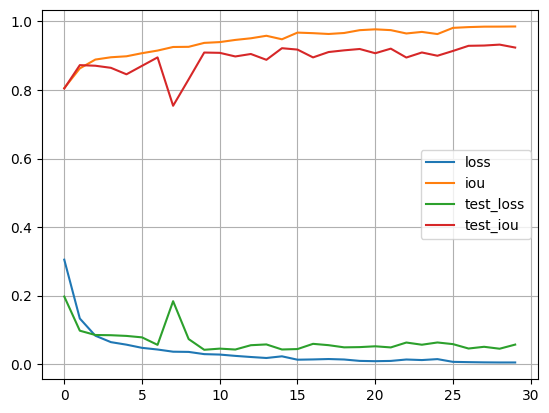

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

<ipython-input-21-0dca32de9b5e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


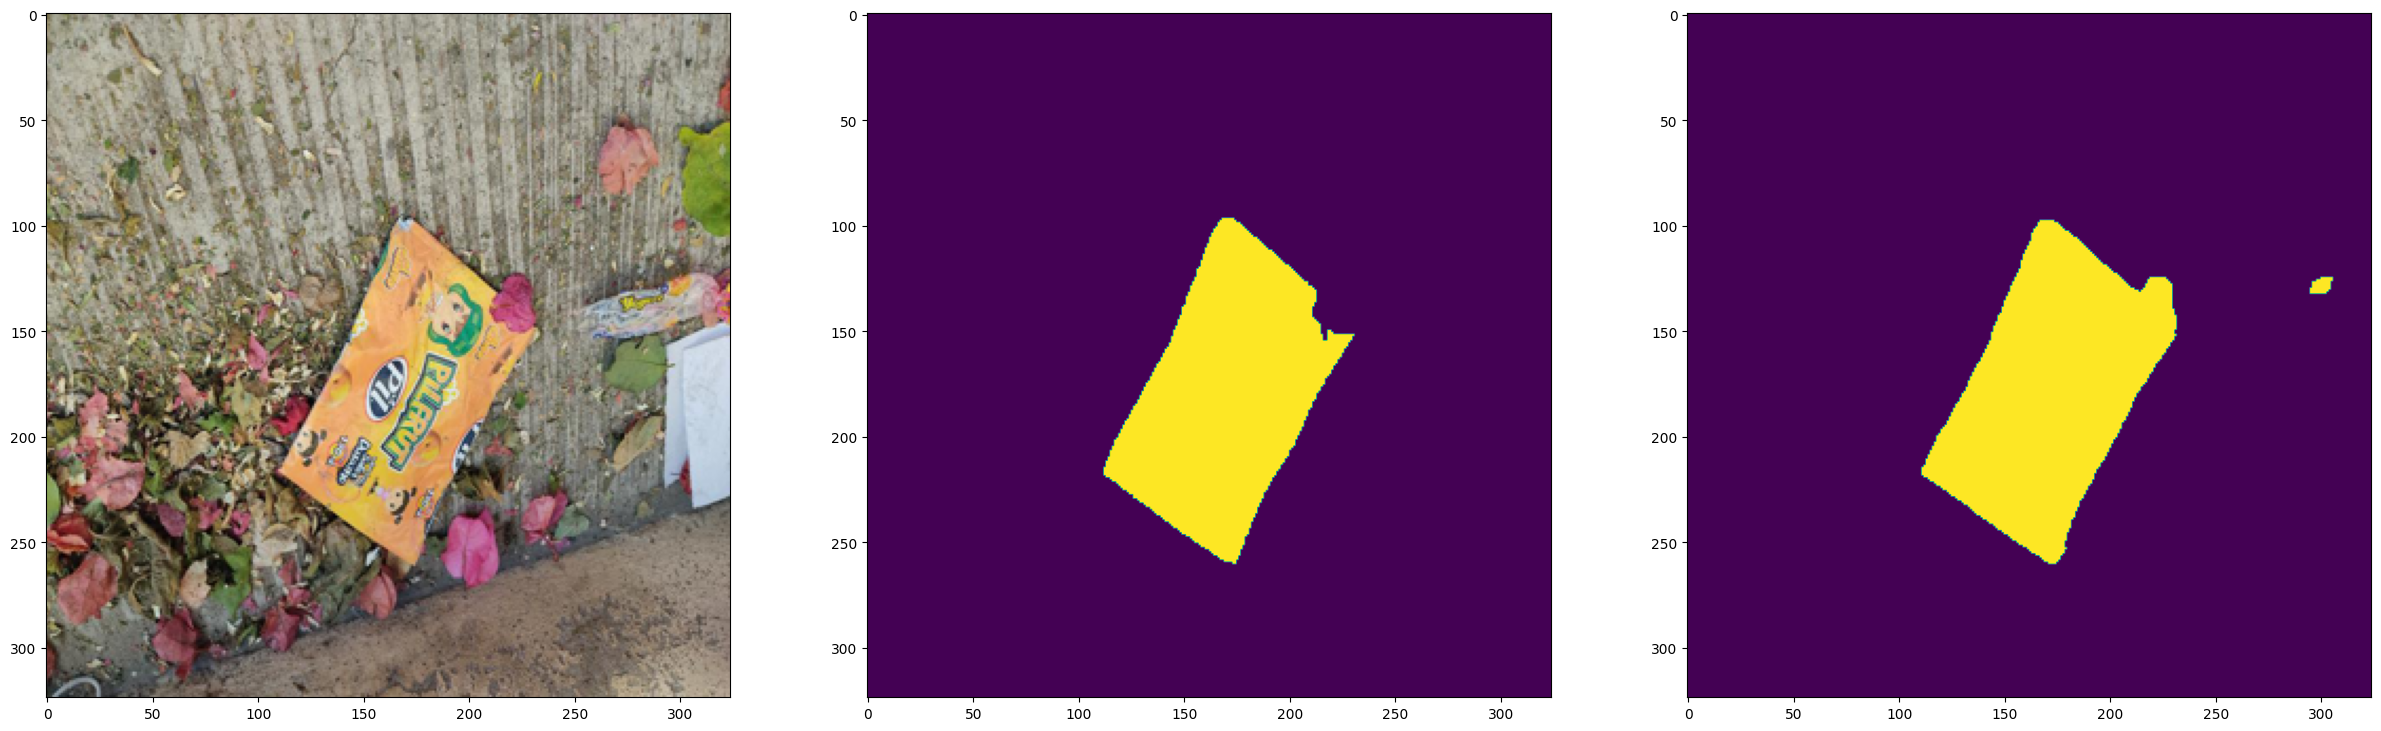

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [ ]:
PATH = './UNetVGG.pt'
torch.save(model.state_dict(), PATH)